In [ ]:
import numpy as np

In [ ]:
# load the data

K = np.loadtxt('ncicancer_kernel_hf_ex0.txt')
y = np.loadtxt('y1.txt')

In [ ]:
K.shape, y.shape

In [ ]:
y

In [ ]:
from sklearn.cross_validation import ShuffleSplit

In [ ]:
cv = ShuffleSplit(K.shape[0], n_iter=5, test_size=500, random_state=42)

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics.regression import r2_score

models = KernelRidge, SVR

scores = {model.__name__: [] for model in models}

for outer_train, outer_test in cv:
    for model in models:
        est = model(kernel='precomputed')
        K_train_train = K[outer_train[:, np.newaxis], outer_train]
        y_train = y[outer_train]
        
        est.fit(K_train_train, y_train)
        K_test_train = K[outer_test[:, np.newaxis], outer_train]
        y_test = y[outer_test]
        pred = est.predict(K_test_train)
        score = r2_score(y_test, pred)
        scores[model.__name__].append(score)

In [ ]:
{key: (np.mean(value), np.std(value)) for key, value in scores.items()}

In [ ]:
alphas = np.logspace(-3, 3, 20)
Cs = np.logspace(3, -3, 20)

models = (KernelRidge, 'alpha', alphas), (SVR, 'C', Cs)


In [ ]:
from sklearn.cross_validation import KFold


In [ ]:
scores = {model[0].__name__: [] for model in models}

for outer_train, outer_test in cv:
    inner_cv = KFold(len(outer_train), n_folds=3)
    for model, param, param_vals in models:
        print("evaluating {}".format(model.__name__))
        inner_scores = []
        K_train_train = K[outer_train[:, np.newaxis], outer_train]
        y_train = y[outer_train]
        K_test_train = K[outer_test[:, np.newaxis], outer_train]
        y_test = y[outer_test]
        for param_val in param_vals:
            #print("testing param {}".format(param_val))
            param_scores = []
            est = model(kernel='precomputed')
            setattr(est, param, param_val)
            for inner_train, inner_test in inner_cv:
                est.fit(K_train_train[inner_train[:, np.newaxis],
                                      inner_train],
                        y_train[inner_train])
                pred = est.predict(K_train_train[
                            inner_test[:, np.newaxis],
                            inner_train])
                score = r2_score(y_train[inner_test], pred)
                param_scores.append(score)
            inner_scores.append(param_scores)
        mean_inner_scores = np.mean(inner_scores, axis=1)
        argbest_param = np.argmax(mean_inner_scores)
        best_param = param_vals[argbest_param]
        print("Best parameter for {}: {}".format(model.__name__, best_param))
        setattr(est, param, best_param)
        est.fit(K_train_train, y_train)
        pred = est.predict(K_test_train)
        score = r2_score(y_test, pred)
        scores[model.__name__].append(score)

In [ ]:
scores

In [ ]:
{key: np.mean(value) for key, value in scores.items()}

# Kernel PCA

In [80]:
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

In [81]:
from sklearn.decomposition import KernelPCA

In [84]:
from sklearn.decomposition import PCA

In [100]:
pca = PCA()
pca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

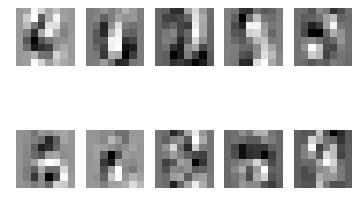

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
for i in range(pca.n_components):
    plt.subplot(2, pca.n_components / 2, i + 1)
    plt.imshow(pca.components_[i].reshape(8, 8), interpolation='nearest')
    plt.gray()
    plt.axis('off')

In [90]:
kpca = KernelPCA(kernel='linear', fit_inverse_transform=True)
kpca.fit(X)

KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=None,
     remove_zero_eig=False, tol=0)

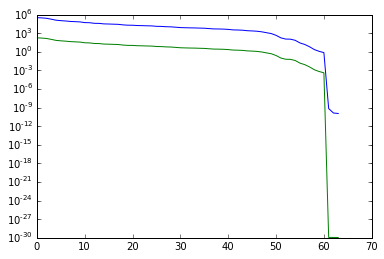

In [101]:
plt.plot(kpca.lambdas_[:64])
plt.plot(pca.explained_variance_)
plt.yscale('log')

In [103]:
kernels = ('rbf', 'gamma', [.01, 1.]), ('poly', 'degree', [1, 3])

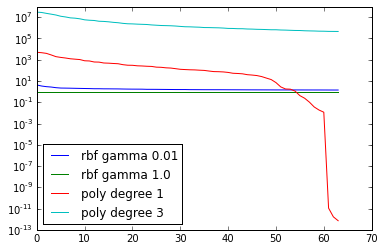

In [108]:
plt.figure()
for kernel, param_name, param_vals in kernels:
    kpca = KernelPCA(kernel=kernel)
    for param_val in param_vals:
        setattr(kpca, param_name, param_val)
        kpca.fit(X)
        plt.plot(kpca.lambdas_[:64], label='{} {} {}'.format(
                    kernel, param_name, param_val))
        plt.yscale('log')
plt.legend(loc='lower left')

In [109]:
KernelPCA??

## transforming and inverse transforming

In [145]:
kpca = KernelPCA(alpha=.1, kernel='rbf', gamma=.1, fit_inverse_transform=True, n_components=60)
cv = ShuffleSplit(len(X), n_iter=1, test_size=500)

train, test = next(iter(cv))

In [146]:
kpca.fit(X[train])

KernelPCA(alpha=0.1, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=0.1, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=60,
     remove_zero_eig=False, tol=0)

In [147]:
Xtrain_pca = kpca.transform(X[train])
Xinv = kpca.inverse_transform(Xtrain_pca)

In [116]:
Xinv.shape

(1297, 64)

In [117]:
Xtrain_pca.shape

(1297, 4)

In [148]:
r2_score(X[train], Xinv)

/home/me232320/software/python_pkg/anaconda/lib/python2.7/site-packages/sklearn/metrics/regression.py:468: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value, it will be changed to 'uniform_average' in 0.18.
  DeprecationWarning)


0.085798974213989382

In [149]:
Xinv.shape

(1297, 64)

In [150]:
36 ** 2

1296

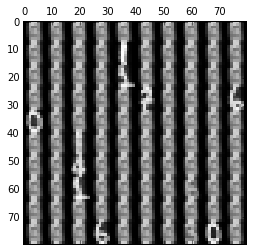

In [152]:
plt.matshow(Xinv[:100].reshape(10, 10, 8, 8).transpose(0, 2, 1, 3).reshape(10 * 8, -1))